In [47]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
import spatialdata as sd
from skimage.measure import regionprops
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import torch.optim as optim
import torch.nn as nn
from geomloss import SamplesLoss
from sklearn.metrics import r2_score
import torch.nn.functional as F
from torchvision import transforms
from scipy.stats import pearsonr
import datetime

from config import DATA_PATH
from data import patch_process
from models import utils as model_utils
from eval import utils as eval_utils

# hugginface
from dotenv import load_dotenv
from huggingface_hub import login
load_dotenv(dotenv_path=os.path.expanduser('~/hl/.gutinstinct.env'))
api_token = os.getenv("API_TOKEN")
login(token=api_token)

SEED = 209

In [2]:
zarr_path = osp.join(os.path.expanduser(DATA_PATH), "UC6_I.zarr/UC6_I.zarr")
sdata = sd.read_zarr(zarr_path)

/home/b-evelyntong/miniconda3/envs/gutinstinct/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [ ]:
## instantiate a uni model
timm_kwargs = {
   'img_size': 224,
   'patch_size': 32,
   'depth': 24,
   'num_heads': 24,
   'init_values': 1e-5,
   'embed_dim': 1536,
   'mlp_ratio': 2.66667*2,
   'num_classes': 0,
   'no_embed_class': True,
   'mlp_layer': timm.layers.SwiGLUPacked,
   'act_layer': torch.nn.SiLU,
   'reg_tokens': 8,
   'dynamic_img_size': True
  }
model_uni = timm.create_model("hf-hub:MahmoodLab/UNI2-h", pretrained=True, **timm_kwargs)
model_uni = model_uni.to('cuda')
transform = create_transform(**resolve_data_config(model_uni.pretrained_cfg, model=model_uni))
model_uni.eval()

In [5]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = f"log_{timestamp}.txt"
patch_id_to_cell_id = patch_process.get_cell_ids_in_patch(sdata, patch_size=200, log_file=log_file)
patch_id_to_pil = patch_process.match_patch_id_to_PIL(sdata, patch_id_to_cell_id, patch_size=200, log_file=log_file)
patch_id_to_cell_id, patch_id_to_pil, patch_id_to_expr = patch_process.match_patch_id_to_expr(sdata, patch_id_to_cell_id, patch_id_to_pil, log_file=log_file)
patch_process.plots_n_visualizations(sdata, patch_id_to_cell_id, patch_id_to_pil, patch_id_to_expr)

In [17]:
# process images, pair with expression vectors
transform = transforms.ToTensor()

# split data into train and validation sets
patch_list = list(patch_id_to_pil.values())
expr_list = list(patch_id_to_expr.values())
patch_train, patch_val, expr_train, expr_val = train_test_split(
    patch_list, expr_list, test_size=0.2, random_state=SEED, shuffle=True
)

# transform pil to tensor and normalize /255, tensorize expression vectors
patch_tensors_train = [transform(patch) for patch in patch_train]
expr_tensors_train = [torch.tensor(e, dtype=torch.float32) for e in expr_train]
patch_tensors_val = [transform(patch) for patch in patch_val]
expr_tensors_val = [torch.tensor(e, dtype=torch.float32) for e in expr_val]

# assemble
train_dataset = TensorDataset(torch.stack(patch_tensors_train), torch.stack(expr_tensors_train))
val_dataset = TensorDataset(torch.stack(patch_tensors_val), torch.stack(expr_tensors_val))

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [18]:
# first try baseline, using cnn + linear regression
# define model
class CNNPlusLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.encoder = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), 
            nn.Flatten(),   
            nn.Linear(64, 128), 
            nn.ReLU()
        )
        self.linear_head = nn.Linear(128, 460)
    
    def forward(self, x):
        x = self.features(x)
        x = self.encoder(x)
        x = self.linear_head(x)
        return x

Epoch 1/50, Train Loss: 0.0331
Epoch 2/50, Train Loss: 0.0285
Epoch 3/50, Train Loss: 0.0257
Epoch 4/50, Train Loss: 0.0246
Epoch 5/50, Train Loss: 0.0243
Epoch 6/50, Train Loss: 0.0241
Epoch 7/50, Train Loss: 0.0240
Epoch 8/50, Train Loss: 0.0238
Epoch 9/50, Train Loss: 0.0235
Epoch 10/50, Train Loss: 0.0233
Epoch 11/50, Train Loss: 0.0231
Epoch 12/50, Train Loss: 0.0229
Epoch 13/50, Train Loss: 0.0227
Epoch 14/50, Train Loss: 0.0227
Epoch 15/50, Train Loss: 0.0225
Epoch 16/50, Train Loss: 0.0225
Epoch 17/50, Train Loss: 0.0223
Epoch 18/50, Train Loss: 0.0223
Epoch 19/50, Train Loss: 0.0221
Epoch 20/50, Train Loss: 0.0221
Epoch 21/50, Train Loss: 0.0219
Epoch 22/50, Train Loss: 0.0218
Epoch 23/50, Train Loss: 0.0217
Epoch 24/50, Train Loss: 0.0215
Epoch 25/50, Train Loss: 0.0215
Epoch 26/50, Train Loss: 0.0213
Epoch 27/50, Train Loss: 0.0212
Epoch 28/50, Train Loss: 0.0210
Epoch 29/50, Train Loss: 0.0209
Epoch 30/50, Train Loss: 0.0208
Epoch 31/50, Train Loss: 0.0206
Epoch 32/50, Trai

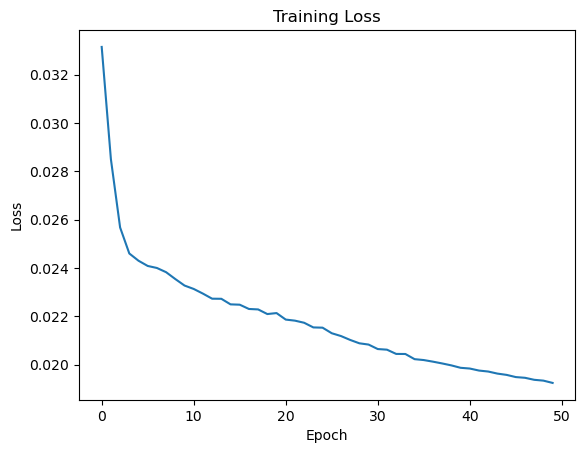

In [ ]:
# train the model
model = CNNPlusLinear()
model.to('cuda')

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

train_losses = []
for epoch in range(50):
    model.train()
    running_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_losses.append(running_train_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{50}, Train Loss: {running_train_loss / len(train_loader):.4f}")


# plot training loss
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("training_loss.png")
plt.show()

In [48]:
# evaluate the model
model.eval()
running_val_loss = 0.0
y_preds = []
y_trues = []
with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        running_val_loss += loss.item()
        y_preds.append(y_pred.cpu().numpy())
        y_trues.append(y_batch.cpu().numpy())

    val_loss = running_val_loss / len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")



Validation Loss: 0.0209


In [49]:
y_preds = np.concatenate(y_preds, axis=0)
y_trues = np.concatenate(y_trues, axis=0)

In [50]:
r2_per_gene = [r2_score(y_trues[:, i], y_preds[:, i]) for i in range(y_trues.shape[1])]
r2_per_samples = [r2_score(y_trues[i], y_preds[i]) for i in range(y_trues.shape[0])]
pearson_per_sample = [pearsonr(y_trues[i, :], y_preds[i, :])[0] for i in range(y_trues.shape[0])]

In [51]:
print(len(r2_per_gene))
print(len(r2_per_samples))
print(len(pearson_per_sample))

460
809
809


In [52]:
r2_per_gene_avg = np.mean(r2_per_gene)
r2_per_samples_avg = np.mean(r2_per_samples)
pearson_per_sample_avg = np.mean(pearson_per_sample)
print(f"Average R2 per gene: {r2_per_gene_avg:.4f}")
print(f"Average R2 per sample: {r2_per_samples_avg:.4f}")
print(f"Average Pearson correlation per sample: {pearson_per_sample_avg:.4f}")

Average R2 per gene: 0.0697
Average R2 per sample: 0.5606
Average Pearson correlation per sample: 0.7532


## Observations
- using a distributional loss in addition to the mse loss does not help the model learn
- train loss plateaus exactly at val loss, the model is not able to overfit
- R2 indicates that the model is worse than predicting the average
- l1 + only wasserstein saw model consistently minimizing loss, but val metrics still bad

Questions to ask:
what loss to use?
is our architecture complete?
any addition we should include?


Notes:
transform from github but didn't use  (create transform function)
